In [ ]:
!conda config --add channels conda-forge
!conda install -y fenics=2016.2

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following NEW packages will be INSTALLED:

    blas:         1.1-openblas            conda-forge
    boost:        1.63.0-np111py35_6      conda-forge
    boost-cpp:    1.63.0-2                conda-forge
    bzip2:        1.0.6-1                 conda-forge
    cairo:        1.14.6-4                conda-forge
    cloog:        0.18.0-0                           
    cmake:        3.9.1-0                 conda-forge
    eigen:        3.3.3-0                 conda-forge
    expat:        2.2.1-0                 conda-forge
    fenics:       2016.2.0-py35_6         conda-forge
    ffmpeg:       3.2.4-1                 conda-forge
    gcc:          4.8.5-7                            
    gettext:      0.19.7-1                conda-forge
    giflib:       5.1.4-0                 conda-forge
    glib:         2.51.4-0                conda-

In [1]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [40]:
# Physical Properties
k = 1                                           # Thermal Conductivity
rho = 2200                                      # Density
c_p = 1100                                      # Specific Heat 
h = Constant('1')                               # Heat transfer coefficient for the Newton's Law of Cooling - Convection
T_en = Constant('30')                           # Temperature of the fluid on the environment

# Create 1D-mesh and define the function space
L = 0.12                                        # Size of 1D domain
nx = 20                                         # Number of elements (nx+1 nodes)
ndx = L / nx                                      # Size of space element
mesh = IntervalMesh(nx,0,L)                     # Create Mesh
V = FunctionSpace(mesh, 'P', 2)                 # Define function space, V with piecewise quadratic elements

# Create time mesh
total_time = 500                                # Duration of simulation time
dt = 5                                          # Time step size
num_steps = int(total_time / dt)                # Number of time steps
t = 0                                           # Define the time variable t
T_profile = []                                  # List of values of T at each time step

In [47]:
# Define boundary conditions
# Dirichilet BC
def left_boundary(x, on_boundary):              # Define function to represent left boundary at position x=0
    return on_boundary and near(x[0], 0)

T_L = Expression('300', degree=1, t=t)          # Define function to represent the temperature at such boundary
dbc = DirichletBC(V, T_L, left_boundary)        # Define the Dirichlet BC

# Robin BC
class right_boundary_class(SubDomain):          # Define class to represent right boundary at position x=L
    def inside(self, x, on_boundary):  
        return near(x[0], L)

bc_right= right_boundary_class()                # Initialize the object bc_right to mark it in the non-Dirichilet boundary
boundaries = FacetFunction('size_t', mesh)      # Get the boundaries of mesh
boundaries.set_all(0)                           # Set all boundary with the flag '0'
bc_right.mark(boundaries,1)                     # Mark the right boundary with the flag '1'
ds = ds(subdomain_data=boundaries)              # Representation of the boundary

# Define initial value
T_0 = Constant('30')                            # Initial temperature value
T_n = interpolate(T_0, V)                       # Initial temperature function at space V

# Define variational problem
u = TrialFunction(V)                            # Define the trial function u to write the variational problem
v = TestFunction(V)                             # Define the test function v to write the variational problem

f = Constant('0')                               # Source term - Heat generated or taken from reactions on the body

F =  rho * c_p * u * v * dx + dt * k * dot(grad(u), grad(v)) * dx - \
    (rho * c_p * T_n + dt * f) * v * dx + dt * h * (u - T_en) * v * ds(1)

a_u_v = lhs(F)                                  # Getting the bilinear form of the variational formulation F, a(u,v)
A = assemble(a_u_v)                             # Assemble of the matrix of the global system of algebric equations 
                                                # (in this case there is no need to assemble inside the loop as the
                                                # coefficients are constant)
L_v = rhs(F)                                    # Getting the linear form of the variational formulation F, L(v)
b = assemble(L_v)                               # Assemble of the global system of algebric equations
dbc.apply(A)                                    # Applying the dirichilet boundary condition in the Matrix A
dbc.apply(b)                                    # Applying the dirichilet boundary condition in vector b


In [48]:
# Time-stepping
T_ = Function(V)                                # Function T in space V to represent the dofs
for n in range(num_steps):

    # Update current time
    t += dt
    T_L.t = t

    # Compute solution
    solve(A,T_.vector(),b,)
    #solve(F == 0, T, bcs=dbc)
    
    # Update previous solution
    T_n.assign(T_)
    
    # List the value
    T_profile.append(T_.compute_vertex_values())

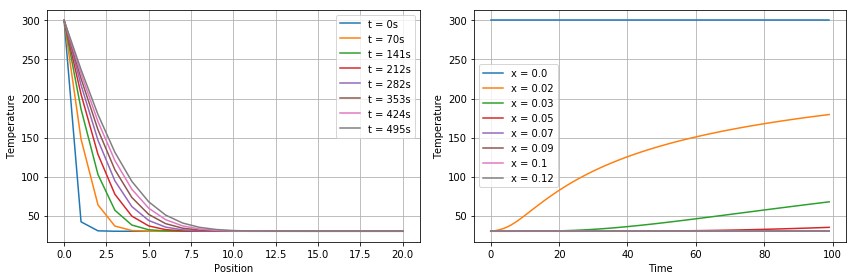

In [49]:
T_his = np.array([T_profile[int(i)] for i in range(num_steps)])             # Data structure to make the temperature history plot

f, axs = plt.subplots(1,2, figsize=(12,4))                                  # Initialize Figure object with two axes

for i in np.linspace(0,num_steps-1,8):                                      # Plot 8 temperature profiles at different times
    axs[0].plot(T_profile[int(i)], label='t = ' + str(int(i*dt)) + 's')
axs[0].set_xlabel('Position')
axs[0].set_ylabel('Temperature')

for i in np.linspace(0,nx,8):                                               # Plot 8 temperature histories at different positions
    axs[1].plot(T_his[:,int(i)], label='x = '+  str(round(i*ndx,2)))
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Temperature')


for ax in axs:                                                              # Add grid and legends
    ax.grid()
    ax.legend(loc='best')

plt.tight_layout()                                                          # Organize displacement of labels
#plt.savefig('T_profile_history.png', dpi=600)                               # Save the figure
plt.show()